In [13]:
%matplotlib inline
import pylab


In [1]:
ls *ng50.txt

iqc.ng50.txt  mqc.ng50.txt  sqc.ng50.txt


In [90]:
def loadme(filename):
    x = []
    for line in open(filename):
        line = line.strip().split(',', 2)
        ng50, ng90, name = line
        ng50 = float(ng50)
        ng90 = float(ng90)
        x.append((ng50, ng90, name))
    return x

iqc = loadme('iqc.ng50.txt')
mqc = loadme('mqc.ng50.txt')
sqc = loadme('sqc.ng50.txt')

In [91]:
index_d = {}
index_d_r = {}
labels = []
import nicenames

for n, ( _, _, name) in enumerate(reversed(mqc)):
    index_d[name] = n
    index_d_r[n] = name
    labels.append(nicenames.nicenames[name])
    
ng50_iqc = {}
ng90_iqc = {}

for ng50, ng90, name in iqc:
    y = index_d[name]
    ng50_iqc[y] = ng50
    ng90_iqc[y] = ng90
    
ng50_mqc = {}
ng90_mqc = {}

for ng50, ng90, name in mqc:
    y = index_d[name]
    ng50_mqc[y] = ng50
    ng90_mqc[y] = ng90

ng50_sqc = {}
ng90_sqc = {}

for ng50, ng90, name in sqc:
    y = index_d[name]
    ng50_sqc[y] = ng50
    ng90_sqc[y] = ng90



In [94]:
max_y = len(index_d)

iqc_x1 = []
iqc_x2 = []
mqc_x1 = []
mqc_x2 = []
sqc_x1 = []
sqc_x2 = []

megahit_lowest = 0
spades_highest = 0

for y in range(max_y):
    iqc_x1.append(ng50_iqc[y])
    iqc_x2.append(ng90_iqc[y])
    
    mqc_x1.append(ng50_mqc[y])
    mqc_x2.append(ng90_mqc[y])

    sqc_x1.append(ng50_sqc[y])
    sqc_x2.append(ng90_sqc[y])
    
#    print(ng50_mqc[y], ng50_iqc[y], ng50_sqc[y])
    if ng50_mqc[y] <= ng50_iqc[y] and ng50_mqc[y] <= ng50_sqc[y]:
        megahit_lowest += 1
#        print('yes')
#    else:
#        print('no', ng50_mqc[y] <= ng50_iqc[y], ng50_mqc[y] <= ng50_sqc[y] )
    if ng50_sqc[y] >= ng50_mqc[y] and ng50_sqc[y] >= ng50_iqc[y]:
        spades_highest += 1
        
print(megahit_lowest)
print(spades_highest)
print(max_y)

42
38
47


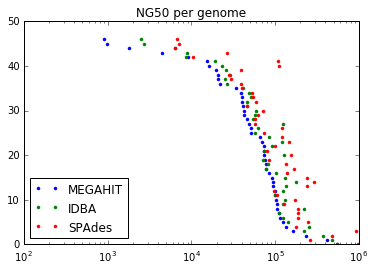

In [93]:
pylab.plot(mqc_x1, range(max_y), '.', label='MEGAHIT')
#pylab.plot(mqc_x2, range(max_y), '.', label='M')
plot = pylab.plot(iqc_x1, range(max_y), '.', label='IDBA')
#pylab.plot(iqc_x2, range(max_y), '.', label='I')

pylab.plot(sqc_x1, range(max_y), '.', label='SPAdes')
#pylab.plot(sqc_x2, range(max_y), '.', label='S')
pylab.xscale('log')
pylab.axis(xmin=100)
pylab.legend(loc='lower left')
pylab.title('NG50 per genome')

pylab.savefig('ng50.pdf')

In [50]:
pylab.yscale

<function matplotlib.pyplot.yscale>

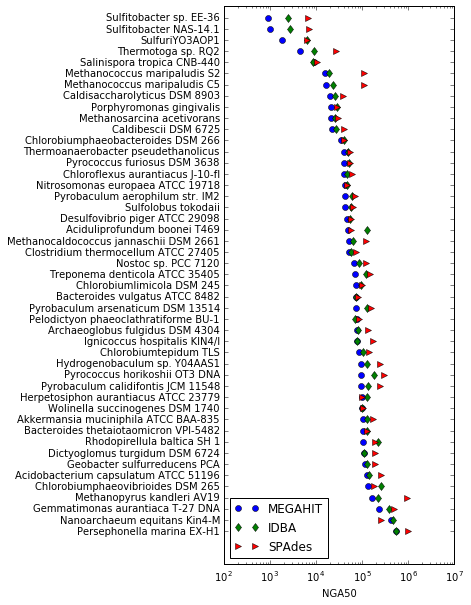

In [83]:
import matplotlib.pyplot as pyplot

fig = pyplot.figure(figsize=(8, 10))
subp = fig.add_subplot(111)
subp.plot(mqc_x1, range(max_y), 'o', label='MEGAHIT')
subp.plot(iqc_x1, range(max_y), 'd', label='IDBA')
subp.plot(sqc_x1, range(max_y), '>', label='SPAdes')

pyplot.setp(subp, yticks=range(max_y))

ytickNames = pyplot.setp(subp, yticklabels=labels)
pyplot.setp(ytickNames, fontsize=10)

pyplot.xscale('log')
pyplot.axis(ymin=-3, xmin=1e2, xmax=1e7, ymax=max_y)
pyplot.xlabel('NGA50')
pylab.legend(loc='lower left')
pyplot.subplots_adjust(left=0.5)

pylab.savefig('nga50.pdf')